In [1]:
!git clone https://github.com/japolak/datahow-course-scripts.git
!cd /content/datahow-course-scripts# TODO: initialize all necessary packages

import pandas as pd
import numpy as np
import scipy
import importlib  
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# import custom modules
transformations = importlib.import_module("datahow-course-scripts.scripts.modules.transformations")
#emulator = importlib.import_module("datahow-course-scripts.scripts.modules.emulator")

#notebook settings
pd.set_option('display.max_rows', None)




Cloning into 'datahow-course-scripts'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 113 (delta 47), reused 84 (delta 21), pack-reused 0
Receiving objects: 100% (113/113), 2.54 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/bin/bash: line 0: cd: too many arguments


# Exploratory Analysis via PCA

TODO: comment on importance of understanding and visualizing data, especially in multivariate setting.

# PCA of OWU matrix

Details of OWU unfolding

### Visualize the OWU matrix

In the OWU matrix, the 1st column corresponds to VCD, the 2nd to glucose, the 3rd to lactate, the 4th to titer, and the 5th to the feed rate.


In [ ]:
filename = "mytable.csv"
owu = transformations.owu_from_csv("datahow-course-scripts/scripts/datasets/"+filename)
owu

### Plot correlation matrix

The OWU matrix is used to plot the degree of correlation between the different variables.

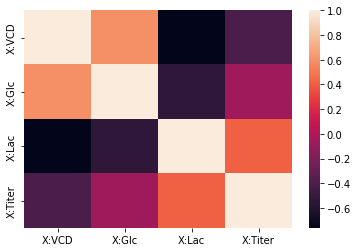

In [149]:
owu.corr()
corr = owu.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Unnormalized PCA

PCA is run on the OWU matrix, without any variable normalization.


In [ ]:
# Select number of components
select_n_components = 4

In [27]:
# Run PCA
pca = PCA(n_components = select_n_components)
pca.fit(owu)
expl_var = pca.explained_variance_
expl_var_ratio_ = pca.explained_variance_ratio_


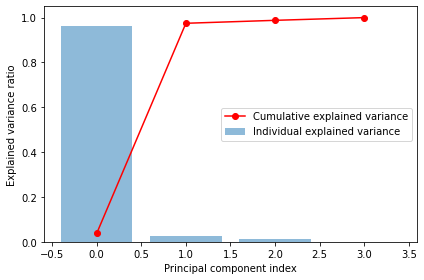

In [23]:
cum_sum_exp = np.cumsum(expl_var_ratio_)
plt.bar(range(0,len(expl_var_ratio_)), expl_var_ratio_, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(expl_var_ratio_)), expl_var_ratio_, where='mid',label='Cumulative explained variance')
plt.plot(range(0,len(expl_var_ratio_)), 1-expl_var_ratio_,"ro-",label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

### Normalized PCA

PCA is run on the OWU matrix, but this time the variables are first normalized with respect to their mean and standard deviation.


In [26]:
# Scale data by mean and standard deviation
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(owu)

In [29]:
pca.fit(scaled_data)
expl_var_scaled = pca.explained_variance_
expl_var_ratio_scaled = pca.explained_variance_ratio_


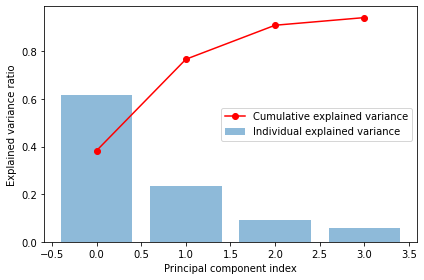

In [30]:
cum_sum_exp = np.cumsum(expl_var_ratio_scaled)
plt.bar(range(0,len(expl_var_ratio_scaled)), expl_var_ratio_scaled, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(0,len(expl_var_ratio_scaled)), 1-expl_var_ratio_scaled,"ro-",label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

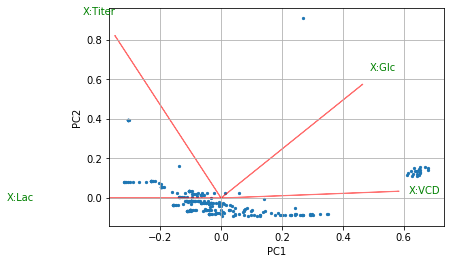

In [31]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
pca_data = pca.fit_transform(scaled_data)
myplot(pca_data[:,0:2],np.transpose(pca.components_[0:2, :]),list(owu.columns))

### Plot scores and loadings

In the following plot, the PCA loadings are plotted together with the observation scores.

Color according to run number / time step / display loadings


In [86]:
# Principal component on x-axis
select_x_pca = 1
# Principal component on y-axis
select_y_pca = 2
# Color plots by
select_coloring = None

Text(0.5, 1.0, 'Score plot')

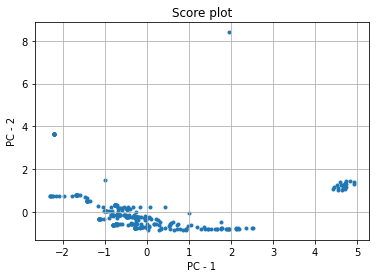

In [44]:
# Score plot of PCA
plt.scatter(pca_data[:,select_x_pca-1],pca_data[:,select_y_pca-1],marker='.')
plt.xlabel("PC - {}".format(select_x_pca))
plt.ylabel("PC - {}".format(select_y_pca))
plt.grid()
plt.title("Score plot")

Text(0.5, 1.0, 'Loadings plot')

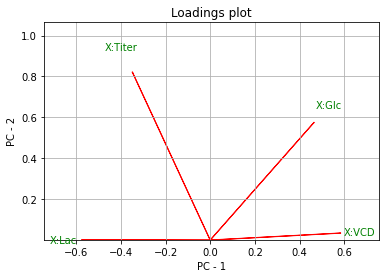

In [85]:
#Loadings plot of PCA
coeff = np.transpose(pca.components_[[select_x_pca-1,select_y_pca-1], :])
labels = list(owu.columns)
for i in range(select_n_components):
    plt.arrow(0,0,coeff[i,0],coeff[i,1],color='r')
    plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim([min(coeff[:,0]*1.3),max(coeff[:,0])*1.3])
plt.ylim([min(coeff[:,1]*1.3),max(coeff[:,1])*1.3])
plt.xlabel("PC - {}".format(select_x_pca))
plt.ylabel("PC - {}".format(select_y_pca))
plt.grid()
plt.title("Loadings plot")


### Task: Normalize by median VCD and run PCA on OWU matrix






# PCA of BWU matrix

Details of BWU unfolding

### Visualize the BWU matrix

In the BWU matrix, the 1st column corresponds to VCD at day 0, the 2nd to glucose at day 0, the 3rd to lactate at day 0, the 4th to titer at day 0, and the 5th to the feed rate at day 0. This is repeated for day 1 and the following days. So, column 6 corresponds to VCD at day1, column 7 corresponds to Glc at day1, ..., column 11 corresponds to VCD at day2, etc.

In [190]:
filename = "mytable.csv"
owu = transformations.owu_from_csv("datahow-course-scripts/scripts/datasets/"+filename)
# bwu = transformations.bwu_from_owu(owu)

In [191]:
# Make nice and add to transformations module
for run_ix,run in owu.groupby("run"):
    if run_ix == 0: # fix
        bwum = run.unstack(level=1)
    elif run_ix < 16 and run_ix >0:
        bwum = pd.concat([bwum, run.unstack(level=1) ])
    #run.unstack(level=0)
#    owu.unstack(level=1)

In [193]:
#bwu_columns = [' '.join(col).strip() for col in bwum.columns.values]
bwu_columns = [str(bwum.columns.get_level_values(0)[i])+str(":")+str(bwum.columns.get_level_values(1)[i]) for i in range(len(bwum.columns.get_level_values(0)))]
bwu = bwum
bwu = pd.DataFrame(bwum.to_numpy(), columns=bwu_columns)
bwu

,X:VCD:0.0,X:VCD:1.0,X:VCD:2.0,X:VCD:3.0,X:VCD:4.0,X:VCD:5.0,X:VCD:6.0,X:VCD:7.0,X:VCD:8.0,X:VCD:9.0,...,X:Titer:5.0,X:Titer:6.0,X:Titer:7.0,X:Titer:8.0,X:Titer:9.0,X:Titer:10.0,X:Titer:11.0,X:Titer:12.0,X:Titer:13.0,X:Titer:14.0
0,12.176471,10.422556,7.357192,4.736131,2.910311,1.744346,1.030814,0.603409,0.351608,0.204346,...,0.032718,0.042836,0.042837,0.042837,0.042838,0.042838,0.042838,0.042838,0.042838,0.042838
1,12.529412,9.558675,5.762142,3.216730,1.738393,0.925018,0.488507,0.256993,0.134930,0.070770,...,0.037794,0.037794,0.037795,0.037795,0.037795,0.037795,0.037795,0.037795,0.037795,0.037795
2,13.588235,12.362525,9.929060,7.457953,5.388989,3.802373,2.643665,1.820726,1.246217,0.849505,...,0.072671,0.072675,0.072677,0.072679,0.072680,0.072681,0.072681,0.072681,0.072682,0.072682
3,14.294118,11.663190,7.412848,4.202947,2.257473,1.180896,0.609367,0.312358,0.159573,0.081381,...,0.043146,0.043146,0.043147,0.043147,0.043147,0.043147,0.043147,0.043147,0.043147,0.043147
4,13.058824,9.872780,5.448547,2.661238,1.238670,0.561719,0.251615,0.112221,0.049955,0.022218,...,0.041294,0.041294,0.041294,0.041294,0.041294,0.041295,0.041295,0.041295,0.041295,0.041295
5,14.647059,10.881271,6.157049,3.183105,1.591715,0.780510,0.379703,0.184050,0.089058,0.043057,...,0.019149,0.019150,0.019150,0.019150,0.019150,0.019150,0.019150,0.019150,0.019150,0.019150
6,14.823529,9.832124,4.548917,1.894548,0.763017,0.302913,0.118953,0.046614,0.018251,0.007144,...,0.069713,0.069713,0.069713,0.069713,0.069713,0.069713,0.069713,0.069713,0.069713,0.069713
7,13.941176,8.822807,3.921816,1.596085,0.627747,0.244126,0.094534,0.036547,0.014120,0.005454,...,0.022046,0.022047,0.022047,0.022047,0.022047,0.022047,0.022047,0.022047,0.022047,0.022047
8,13.764706,8.369462,3.523939,1.360488,0.514589,0.212801,0.186659,0.075539,0.027684,0.010141,...,0.145025,0.288689,0.303750,0.303750,0.303750,0.303750,0.303750,0.303750,0.303750,0.303750
9,14.470588,12.515381,9.328689,6.557793,4.477432,3.009797,1.998509,1.318572,0.866733,0.568381,...,0.104935,0.108756,0.108759,0.108760,0.108761,0.108762,0.108762,0.108763,0.108763,0.108763


### Plot correlation matrix
The BWU matrix is used to plot the degree of correlation between the different variables.


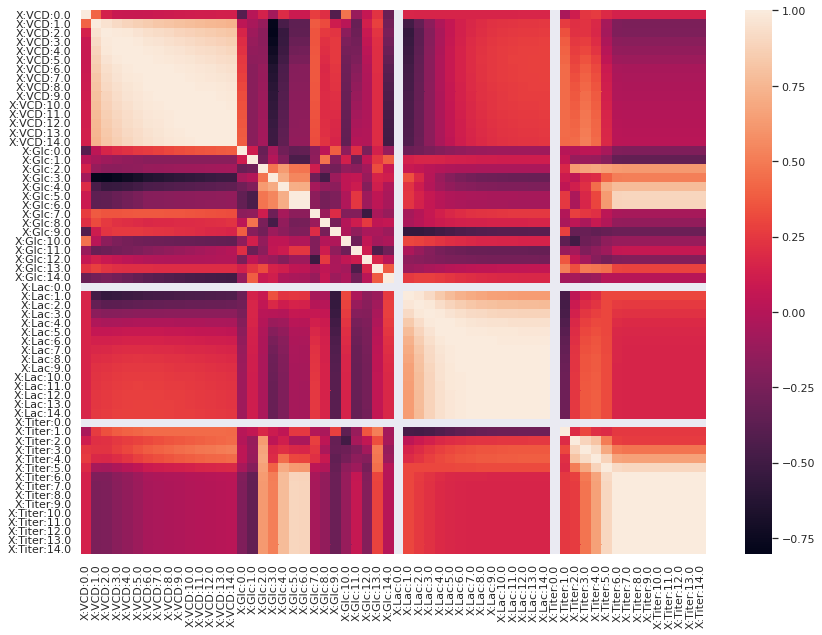

In [194]:
#owu.corr()
sns.set(rc={'figure.figsize':(14,10)})
corr = bwu.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Normalized PCA

PCA is run on the BWU matrix, bu this time the variables are first normalized with respect to their mean and standard deviation.


In [207]:
pca = PCA(n_components=min(bwu.shape))
# Scale data by mean and standard deviation
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(bwu)
pca.fit(scaled_data)
expl_var_scaled = pca.explained_variance_
expl_var_ratio_scaled = pca.explained_variance_ratio_


In [208]:
expl_var_ratio_

array([9.62570288e-01, 2.52777050e-02, 1.21471332e-02, 4.87354133e-06])

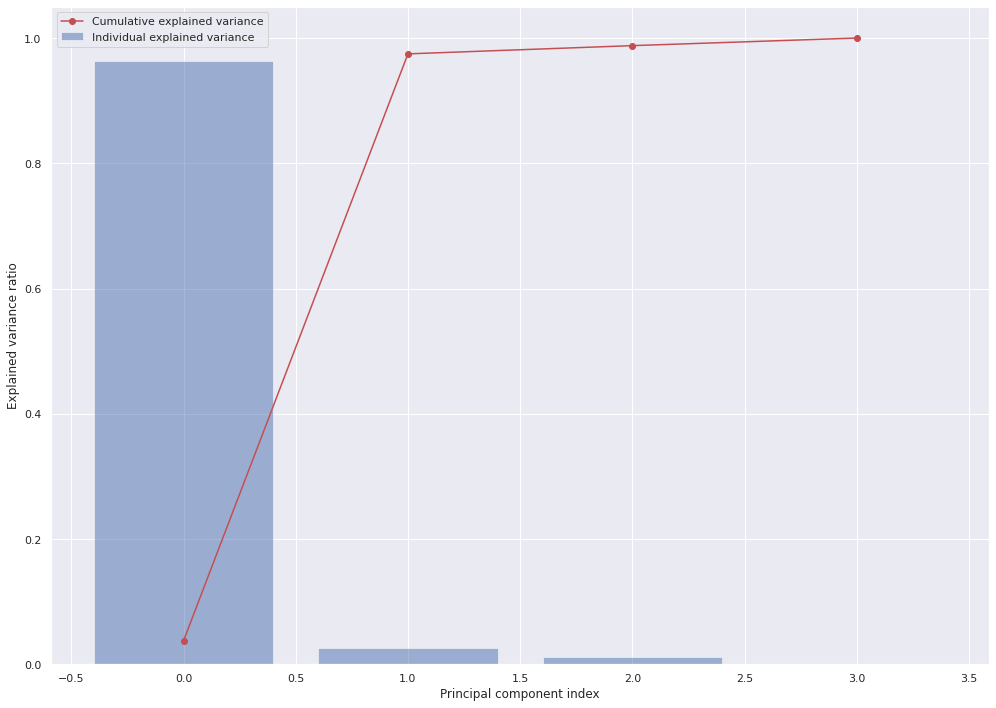

In [209]:
cum_sum_exp = np.cumsum(expl_var_ratio_)
plt.bar(range(0,len(expl_var_ratio_)), expl_var_ratio_, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(expl_var_ratio_)), expl_var_ratio_, where='mid',label='Cumulative explained variance')
plt.plot(range(0,len(expl_var_ratio_)), 1-expl_var_ratio_,"ro-",label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

### Plot scores and loadings

In the following plot, the PCA loadings are plotted first with the loadings and then without.


In [211]:
# Principal component on x-axis
select_x_pca = 1
# Principal component on y-axis
select_y_pca = 2
# Color plots by
select_coloring = None

Text(0.5, 1.0, 'Score plot')

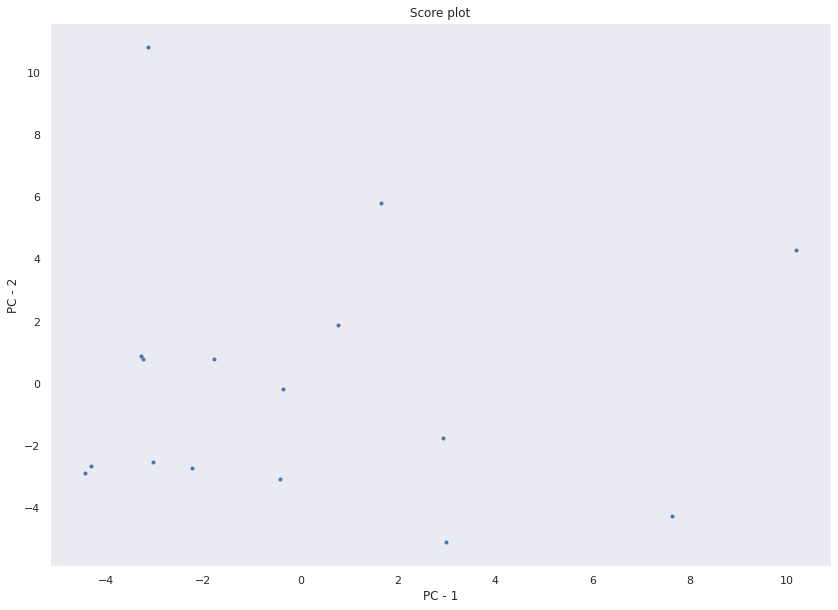

In [212]:
# Score plot of PCA
plt.scatter(pca_data[:,select_x_pca-1],pca_data[:,select_y_pca-1],marker='.')
plt.xlabel("PC - {}".format(select_x_pca))
plt.ylabel("PC - {}".format(select_y_pca))
plt.grid()
plt.title("Score plot")

Text(0.5, 1.0, 'Loadings plot')

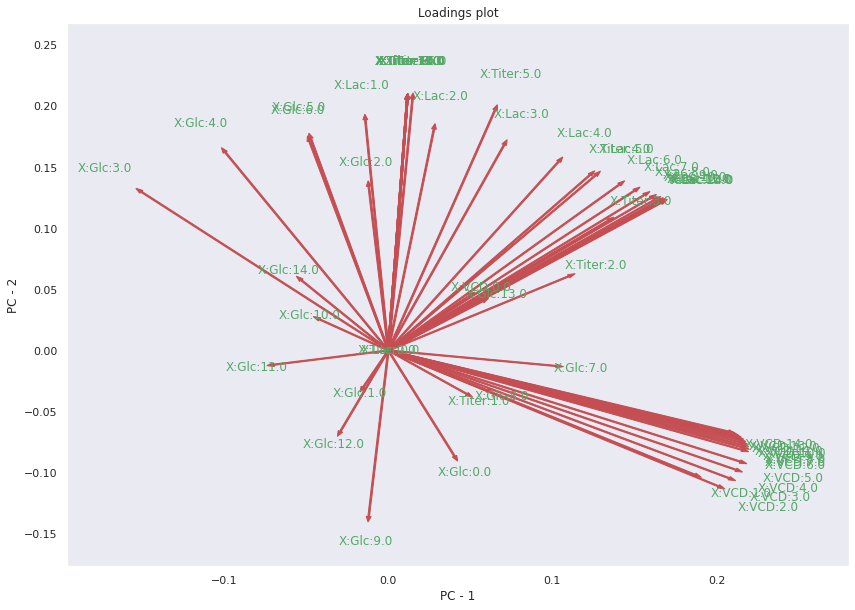

In [216]:
#Loadings plot of PCA
coeff = np.transpose(pca.components_[[select_x_pca-1,select_y_pca-1], :])
labels = list(bwu.columns)
for i in range(len(coeff)):
    plt.arrow(0,0,coeff[i,0],coeff[i,1],color='r')
    plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim([min(coeff[:,0]*1.3),max(coeff[:,0])*1.3])
plt.ylim([min(coeff[:,1]*1.3),max(coeff[:,1])*1.3])
plt.xlabel("PC - {}".format(select_x_pca))
plt.ylabel("PC - {}".format(select_y_pca))
plt.grid()
plt.title("Loadings plot")


### Task: Compute Mahalanobis distances on BWU matrix

# Solutions to tasks


# Main focus process characterization
* degrees of freedom
* univariate visualization
* abnormalities

# Main focus PCA
* abnormalities in runs/variables
* interpretation scores/loadings
* differences between OWU/BWU
